### Transformer Seq2Seq (Neural Signals to Bi-grams)

This notebook contains code for running a 2-word seq2seq Transformer where the neural signals are sent through the encoder while the corresponding bi-grams are sent through the decoder.

Set the seed for reproducibility. For more info read https://pytorch.org/docs/stable/notes/randomness.html and https://discuss.pytorch.org/t/random-seed-initialization/7854/18

In [14]:
import json
import math
import os
import random
import sys
import time
import warnings
from collections import Counter
from datetime import datetime
from pprint import pprint

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data as data
from transformers import AdamW

from arg_parser import arg_parser
from build_matrices import (build_design_matrices_classification,
                            build_design_matrices_seq2seq)
from config import build_config
from dl_utils import Brain2enDataset, MyCollator
from models import PITOM, ConvNet10, MeNTAL, MeNTALmini
from train_eval import plot_training, train, valid
from eval_utils import evaluate_roc, evaluate_topk
from vocab_builder import get_sp_vocab, get_std_vocab, get_vocab

In [15]:
results_folder = '20200523-ipynb'

In [16]:
args = arg_parser(['--subjects', '625', '676', '--max-electrodes', '55', '64'])

In [17]:
# Model objectives
MODEL_OBJ = {
    "ConvNet10": "classifier",
    "PITOM": "classifier",
    "MeNTALmini": "classifier",
    "MeNTAL": "seq2seq"
}

# GPUs
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
args.gpus = min(args.gpus, torch.cuda.device_count())

# Fix random seed
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)

args.model = args.model.split("_")[0]
classify = False if (args.model in MODEL_OBJ
                     and MODEL_OBJ[args.model] == "seq2seq") else True

In [18]:
CONFIG = build_config(args, results_folder)

Subject: 625
Training Data:: Number of Conversations is: 63
Validation Data:: Number of Conversations is: 13
Subject: 676
Training Data:: Number of Conversations is: 49
Validation Data:: Number of Conversations is: 24


In [19]:
word2freq, word_list, n_classes, vocab, i2w = get_std_vocab(
    CONFIG, comprehension=False, classify=classify)

# Conversations: 112
Vocabulary size (min_freq=1): 4467
Saving word counter


In [20]:
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick

plt.rc('text', usetex=False)
plt.rc('font', family='serif')


def figure1(SAVE_DIR, word2freq):
    '''Plotting histogram of word frequency'''
    try:
        k = list(word2freq.values())
    except:
        k = word2freq
    k = list(filter((-1).__ne__, k))
    fig, ax = plt.subplots()
    ax.plot(range(len(k)), sorted(k))
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(len(word2freq)))
    plt.title('Frequency of words (sorted)', fontsize=16)
    plt.xlabel('Percentage of Words', fontsize=16)
    plt.ylabel('Word Frequency', fontsize=16)
    plt.yscale('log')
    plt.grid(True, which='both')
    plt.savefig(os.path.join(SAVE_DIR, 'word_frequency.svg'))
    plt.show(fig)


def figure2(SAVE_DIR, word2freq):
    bins = [0, 5, 10, 20, 30, 40, 50, 100, 250, 500, 750, 1000, 5000]
    try:
        k = list(word2freq.values())
    except:
        k = word2freq
    k = list(filter((-1).__ne__, k))
    categories = pd.cut(k, bins)
    price_binned = pd.value_counts(categories).reindex(categories.categories)
    
    fig, ax = plt.subplots()
    ax.bar(range(0, len(bins)-1), price_binned, width=1, align='edge')
    plt.xticks(range(len(bins)), labels=bins, rotation='45')

    for i, v in enumerate(price_binned.values):
        ax.text(i + 0.25, v + 5, str(v), color='blue', fontweight='bold')
    
    plt.title('Distribution of Words Frequency', fontsize=16)
    plt.xlabel('Word Frequency', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.savefig(os.path.join(SAVE_DIR, 'word_frequency_dist.svg'))
    plt.show()

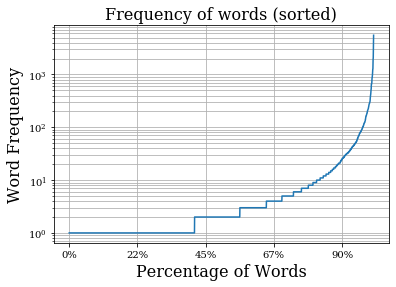

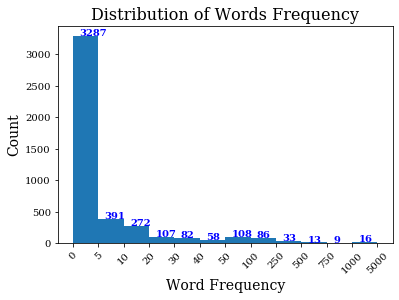

In [21]:
figure1(CONFIG["SAVE_DIR"], word2freq)
figure2(CONFIG["SAVE_DIR"], word2freq)

In [22]:
args = arg_parser(['--subjects', '625', '676',
                   '--max-electrodes', '55', '64',
                   '--vocab-min-freq', '10',
                   '--vocab-max-freq', '250'])
CONFIG = build_config(args, results_folder)

Subject: 625
Training Data:: Number of Conversations is: 63
Validation Data:: Number of Conversations is: 13
Subject: 676
Training Data:: Number of Conversations is: 49
Validation Data:: Number of Conversations is: 24


In [23]:
word2freq, word_list, n_classes, vocab, i2w = get_std_vocab(
    CONFIG, comprehension=False, classify=classify)

# Conversations: 112
Vocabulary size (min_freq=10): 769
Saving word counter


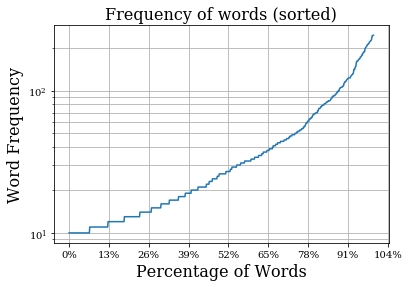

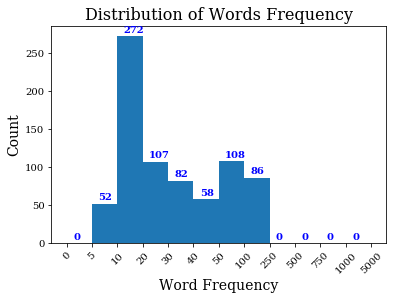

In [24]:
figure1(CONFIG["SAVE_DIR"], word2freq)
figure2(CONFIG["SAVE_DIR"], word2freq)

In [12]:
print("Loading training data")
x_train, y_train = build_design_matrices_seq2seq(
    'train', CONFIG, vocab, delimiter=" ", aug_shift_ms=[-1000, -500])

print("Loading validation data")
x_valid, y_valid = build_design_matrices_seq2seq(
    'valid', CONFIG, vocab, delimiter=" ", aug_shift_ms=[], remove_unks=False)

Loading training data
Skipping bad conversation: /scratch/gpfs/hgazula/brain2en-seq2seq-data/676-conversations/NY676_617_Part1_conversation5
Maximum Sequence Length (Preset): None
Number of train samples is: 9999
Number of train labels is: 9999
Maximum Sequence Length: 5221
Loading validation data
Maximum Sequence Length (Preset): None
Number of valid samples is: 13429
Number of valid labels is: 13429
Maximum Sequence Length: 5512


### Some insights about the bigrams in the training set

In [25]:
def seq_len_stats(x_train, x_valid):
    train_seq_lengths = [sample.shape[0] for sample in x_train]
    valid_seq_lengths = [sample.shape[0] for sample in x_valid]
    print("Training Seq Lengths::")
    print(f"\tMin: {min(train_seq_lengths)}") 
    print(f"\tMax: {max(train_seq_lengths)}")
    print(f"\tMean: {np.mean(train_seq_lengths):.2f}")
    print(f"\tMedian: {np.median(train_seq_lengths):.2f}")
    print(f"\tStd: {np.std(train_seq_lengths):.2f}")

    print("Validation Seq Lengths::")
    print(f"\tMin: {min(valid_seq_lengths)}") 
    print(f"\tMax: {max(valid_seq_lengths)}")
    print(f"\tMean: {np.mean(valid_seq_lengths):.2f}")
    print(f"\tMedian: {np.median(valid_seq_lengths):.2f}")
    print(f"\tStd: {np.std(valid_seq_lengths):.2f}")
    
    return train_seq_lengths, valid_seq_lengths
    
def figure4(SAVE_DIR, lengths, string):
    '''Plotting histogram of Training Signal Lengths'''
    fig, ax = plt.subplots()
    ax.plot(range(len(lengths)), sorted(lengths))
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(len(lengths)))
    plt.title(string + ' set Seq lengths (sorted)', fontsize=16)
    plt.xlabel('Percentage of Samples', fontsize=14)
    plt.ylabel('Sequence Length', fontsize=14)
    plt.yscale('log')
    plt.grid(True, which='both')
    plt.savefig(os.path.join(SAVE_DIR, string + '_signal_len.svg'))
    plt.show(fig)
    

def figure5(SAVE_DIR, lengths, string):
    bins = [0, 25, 50, 75, 100, 250, 500, 1000, 2500, 5000, 7500, 10000]

    categories = pd.cut(lengths, bins)
    price_binned = pd.value_counts(categories).reindex(categories.categories)
    
    fig, ax = plt.subplots()
    ax.bar(range(0, len(bins)-1), price_binned, width=1, align='edge')
    plt.xticks(range(len(bins)), labels=bins)

    for i, v in enumerate(price_binned.values):
        ax.text(i + 0.25, v + 5, str(v), color='blue', fontweight='bold')
    
    plt.title(f'Distribution of Seq lengths ({string})', fontsize=14)
    plt.xlabel('Sequence Length', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.savefig(os.path.join(SAVE_DIR, string + '_signal_len_dist.svg'))
    plt.show()
    

def figure6(SAVE_DIR, lengths, string):
    plt.hist(lengths, bins=1000)
    plt.xlim([0, 100])
    plt.title(f'Distribution of Seq lengths ({string})', fontsize=14)
    plt.xlabel('Sequence Length', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.savefig(os.path.join(SAVE_DIR, string + '_signal_len_dist_zoom.svg'))
    plt.show()

Training Seq Lengths::
	Min: 42
	Max: 5221
	Mean: 54.70
	Median: 48.00
	Std: 94.88
Validation Seq Lengths::
	Min: 42
	Max: 5512
	Mean: 54.92
	Median: 47.00
	Std: 106.07


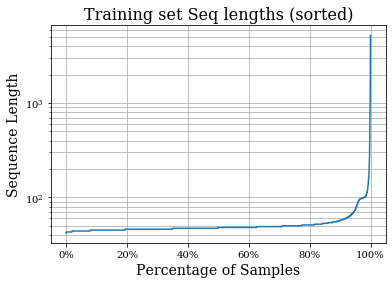

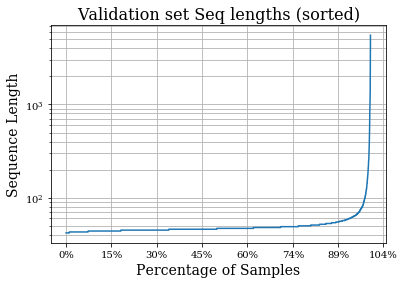

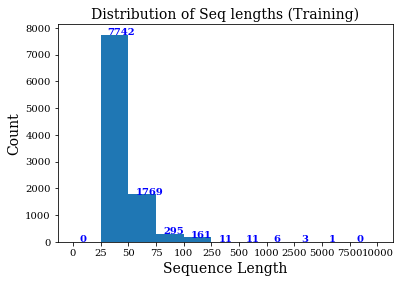

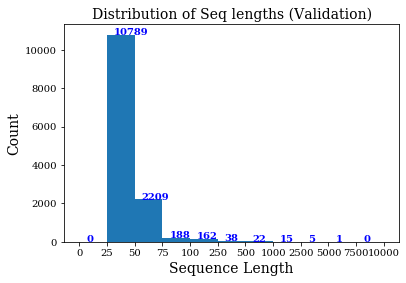

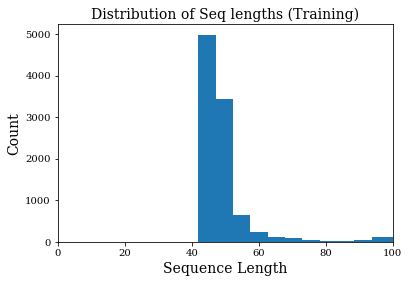

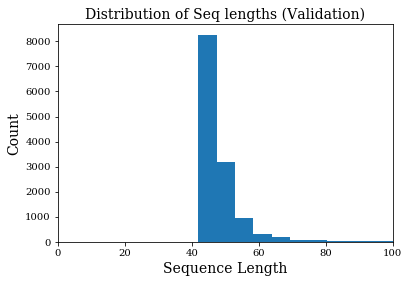

In [26]:
train_seq_lengths, valid_seq_lengths = seq_len_stats(x_train, x_valid)
    
figure4(CONFIG["SAVE_DIR"], train_seq_lengths, 'Training')
figure4(CONFIG["SAVE_DIR"], valid_seq_lengths, 'Validation')

figure5(CONFIG["SAVE_DIR"], train_seq_lengths, 'Training')
figure5(CONFIG["SAVE_DIR"], valid_seq_lengths, 'Validation')

figure6(CONFIG["SAVE_DIR"], train_seq_lengths, 'Training')
figure6(CONFIG["SAVE_DIR"], valid_seq_lengths, 'Validation')

In [27]:
print("Loading training data")
x_train, y_train = build_design_matrices_seq2seq(
    'train', CONFIG, vocab, delimiter=" ", aug_shift_ms=[-1000, -500], max_num_bins=60)

print("Loading validation data")
x_valid, y_valid = build_design_matrices_seq2seq(
    'valid', CONFIG, vocab, delimiter=" ", aug_shift_ms=[], max_num_bins=60, remove_unks=False)

print("Loading validation data")
x_valid, y_valid = build_design_matrices_seq2seq(
    'valid', CONFIG, vocab, delimiter=" ", aug_shift_ms=[], max_num_bins=60, remove_unks=True)

Loading training data
Skipping bad conversation: /scratch/gpfs/hgazula/brain2en-seq2seq-data/676-conversations/NY676_617_Part1_conversation5
Maximum Sequence Length (Preset): 60
Number of train samples is: 9208
Number of train labels is: 9208
Maximum Sequence Length: 60
Loading validation data
Maximum Sequence Length (Preset): 60
Number of valid samples is: 12538
Number of valid labels is: 12538
Maximum Sequence Length: 60
Loading validation data
Maximum Sequence Length (Preset): 60
Number of valid samples is: 2280
Number of valid labels is: 2280
Maximum Sequence Length: 60


In [28]:
train_seq_lengths, valid_seq_lengths = seq_len_stats(x_train, x_valid)

Training Seq Lengths::
	Min: 42
	Max: 60
	Mean: 47.88
	Median: 47.00
	Std: 3.14
Validation Seq Lengths::
	Min: 42
	Max: 60
	Mean: 47.77
	Median: 47.00
	Std: 3.11


In [29]:
def replace_words(data):
    df_y_train = pd.DataFrame(data)
    df_y_train[1].replace(i2w, inplace=True)
    df_y_train[2].replace(i2w, inplace=True)

    return df_y_train

In [30]:
def bigram_freq_excel(data, word2freq, i2w, filename, ref_data=None):
    valid_df = replace_words(data)
    valid_df = valid_df.groupby([1, 2]).size().reset_index(name='Count')
    valid_df['BF1'] = valid_df[1].replace(dict(valid_df[1].value_counts()))
    valid_df['BF2'] = valid_df[2].replace(dict(valid_df[2].value_counts()))
    valid_df['VF1'] = valid_df[1].replace(word2freq)
    valid_df['VF2'] = valid_df[2].replace(word2freq)

    if ref_data is not None:
        valid_df = valid_df.merge(ref_data, on=[1, 2], suffixes=('_valid', '_train'), how='left') 
        
    valid_df.to_excel(os.path.join(CONFIG["SAVE_DIR"], filename), index=False)
        
    print(len(valid_df[1].unique()))
    print(len(valid_df[2].unique()))

    print(set(word2freq.keys()) - set(valid_df[1].unique()))
    print(set(word2freq.keys()) - set(valid_df[2].unique()))
    
    return valid_df

In [31]:
train_df = bigram_freq_excel(y_train, word2freq, i2w, "625+676_bi-gram-freq-train.xlsx")
_ = bigram_freq_excel(y_valid, word2freq, i2w, "625+676_bi-gram-freq-valid.xlsx", ref_data=train_df)

707
702
{'kidding', 'children', 'throat', 'believe', 'chance', 'button', '<s>', 'ice', 'starting', 'vitamins', 'under', 'cute', 'understood', 'above', 'figure', 'microscope', 'example', 'opinion', 'amount', 'boys', 'type', 'parts', 'themselves', 'therapy', 'needs', 'museum', '<pad>', 'oatmeal', 'fortified', 'mm', 'glasses', 'bye', 'helped', 'cereal', "what'd", 'shell', 'airplane', 'uhuh', 'bunch', '<unk>', '</s>', 'whenever', 'wants', 'used', 'language', 'hat', 'effect', 'nah', 'listening', 'lie', 'envelope', 'popping', 'outside', 'ear', 'ball', 'supposed', 'studied', 'plenty', 'season', 'violin', 'rest', 'cow'}
{'yo', 'grandpa', 'stopped', 'husband', 'spoke', 'scared', 'ate', 'table', '<s>', 'depends', 'microscope', 'seriously', 'fiance', 'forget', 'guess', 'worst', 'promise', 'hey', '<pad>', 'fortified', 'mm', 'bag', 'miss', 'middle', 'sister', 'lot', 'mouth', "what'd", 'aw', 'eyes', 'bathroom', "could've", 'says', "should've", 'asked', 'apple', 'random', 'front', 'umbrella', 'uhuh',

In [ ]:
# def figure6(SAVE_DIR, df, word2freq, string):
#     sorted_w2f = sorted(word2freq.items())
#     l = [a[1] for a in sorted_w2f if a[1] != -1]
#     plt.plot(df[1].value_counts().sort_index(), marker='.', markersize = 2.5, linewidth=0.25)
#     plt.plot(df[2].value_counts().sort_index(), marker='.', markersize = 2.5, linewidth=0.25)
#     plt.plot(l, marker='.', markersize = 2.5, linewidth=0.25, color='k')
#     plt.xticks(list(range(0, len(vocab), 50)), list(range(0, len(vocab), 50)))
#     plt.legend(['First word', 'Second Word', 'Actual'])
#     plt.xlabel('Word Index', fontsize=14)
#     plt.ylabel('Frequency', fontsize=14)
#     plt.yscale('log')
#     plt.title(f'Frequency of each word in the bigram ({string})', fontsize=14)
#     plt.savefig(os.path.join(SAVE_DIR, string + '_bigram-Freq.svg'))
#     plt.show()
    
# figure6(SAVE_DIR, train_df, word2freq, 'Training')
# figure6(SAVE_DIR, train_df, word2freq, 'Validation')

#### Converting train and validation data to Loader objects

#### Creating a Model